# Imports
## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import cv2
import h5py

import tensorflow as tf

import os

! pip install pyyaml h5py  # Required to save models in HDF5 format

print("Imports complete")

Imports complete


## Loading the dataset

In [2]:
dir = "../input/covid19-radiography-database/COVID-19_Radiography_Dataset"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir, labels = "inferred", label_mode = "int", 
    color_mode = "rgb", batch_size = 32, image_size = (224, 224), 
    shuffle = True, seed = 42, validation_split = 0.2, subset = "training", interpolation = "bicubic")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dir, labels = "inferred", label_mode = "int", 
    color_mode = "rgb", batch_size = 32, image_size = (224, 224), 
    shuffle = True, seed = 42, validation_split = 0.2, subset = "validation", interpolation = "bicubic")

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


2022-01-09 20:04:53.428304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 20:04:53.539933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 20:04:53.540956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-09 20:04:53.544013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [3]:
class_names = train_ds.class_names
print(class_names)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


### Preparing the dataset
- *One-Hot Encoding* the labels
- *Normalizing* the input images

In [4]:
#One hot encoding
train_ds = train_ds.map(lambda x, y : (x, tf.one_hot(y, depth = 4)))
val_ds = val_ds.map(lambda x, y : (x, tf.one_hot(y,depth = 4)))

#Normalization
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

### Optimizing the dataset

In [5]:
"""
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds
"""

'\ndef configure_for_performance(ds):\n    ds = ds.cache()\n    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)\n    return ds\n'

In [6]:
"""
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
"""

'\ntrain_ds = configure_for_performance(train_ds)\nval_ds = configure_for_performance(val_ds)\n'

# Data Augmentation
The paper: [The Effectiveness of Image Augmentation in Deep Learning Networks for Detecting COVID-19: A Geometric Transformation Perspective](https://www.frontiersin.org/articles/10.3389/fmed.2021.629134/full) reveals that geometric augmentation won't be of much help in classification of COVID-19 and non-COVID-19 viral pneumonia.

# The Models

# A very basic *ConvNet*
Similar to *LeNet-5* architecture

In [7]:
def convolutional_model(input_shape):
    
    input_img = tf.keras.Input(shape=input_shape)
    
    Z1 = tf.keras.layers.Conv2D( filters = 8, kernel_size = 4, strides = ( 1, 1 ), padding = 'SAME' )(input_img)
    
    A1 = tf.keras.layers.ReLU( )(Z1)
    
    P1 = tf.keras.layers.MaxPool2D( pool_size = ( 8, 8 ), strides = ( 8, 8 ), padding = 'same' )(A1)
    
    Z2 = tf.keras.layers.Conv2D( filters = 16, kernel_size = 2, strides = ( 1, 1 ), padding = 'same' )(P1)
    
    A2 = tf.keras.layers.ReLU()(Z2)
    
    P2 = tf.keras.layers.MaxPool2D( pool_size = (4, 4), strides = (4, 4), padding = 'same' )(A2)
    
    F = tf.keras.layers.Flatten()(P2)
    
    outputs = tf.keras.layers.Dense(units = 4, activation = "softmax")(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [8]:
checkpoint_path = 'training/conv/conv_cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=False,
                                                save_freq ='epoch',
                                                verbose=1)

In [9]:
conv_model = convolutional_model((224, 224, 3))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
conv_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 8)       392       
_________________________________________________________________
re_lu (ReLU)                 (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        528       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0     

### Training the model

In [10]:
historyC = conv_model.fit(train_ds, 
                          epochs=30, 
                          validation_data=val_ds, 
                          callbacks = [cp_callback])
conv_model.save('conv_model.h5')

2022-01-09 20:05:01.601107: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-01-09 20:05:04.919908: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


530/530 [==============================] - 103s 177ms/step - loss: 0.8182 - accuracy: 0.6583 - precision: 0.7513 - recall: 0.5310 - val_loss: 0.6664 - val_accuracy: 0.7257 - val_precision: 0.7566 - val_recall: 0.6815

Epoch 00001: saving model to training/conv/conv_cp.ckpt


2022-01-09 20:06:44.976954: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/30
530/530 [==============================] - 59s 110ms/step - loss: 0.5919 - accuracy: 0.7711 - precision: 0.8082 - recall: 0.7215 - val_loss: 0.5536 - val_accuracy: 0.7921 - val_precision: 0.8256 - val_recall: 0.7527

Epoch 00002: saving model to training/conv/conv_cp.ckpt
Epoch 3/30
530/530 [==============================] - 60s 111ms/step - loss: 0.5162 - accuracy: 0.8060 - precision: 0.8319 - recall: 0.7708 - val_loss: 0.5120 - val_accuracy: 0.8037 - val_precision: 0.8251 - val_recall: 0.7777

Epoch 00003: saving model to training/conv/conv_cp.ckpt
Epoch 4/30
530/530 [==============================] - 60s 111ms/step - loss: 0.4746 - accuracy: 0.8247 - precision: 0.8467 - recall: 0.7970 - val_loss: 0.4631 - val_accuracy: 0.8202 - val_precision: 0.8446 - val_recall: 0.7949

Epoch 00004: saving model to training/conv/conv_cp.ckpt
Epoch 5/30
530/530 [==============================] - 61s 114ms/step - loss: 0.4473 - accuracy: 0.8352 - precision: 0.8538 - recall: 0.8116 - val_lo

### Evaluation of the trained model

In [11]:
l = historyC.history.keys()
print(l, len(l), type(l))

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall']) 8 <class 'dict_keys'>


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.p

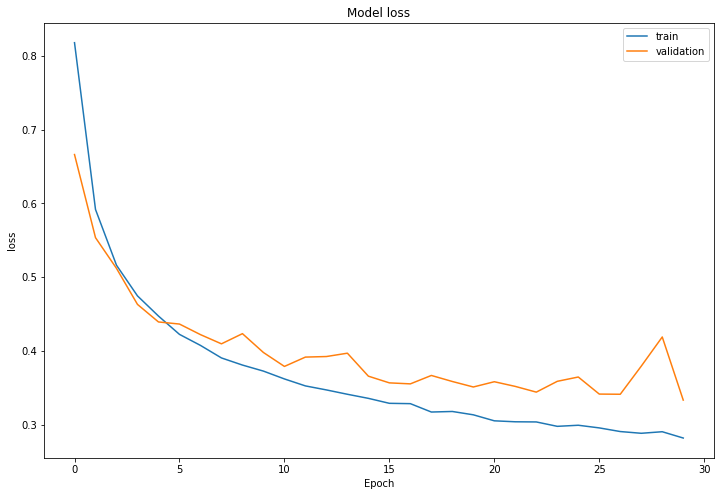

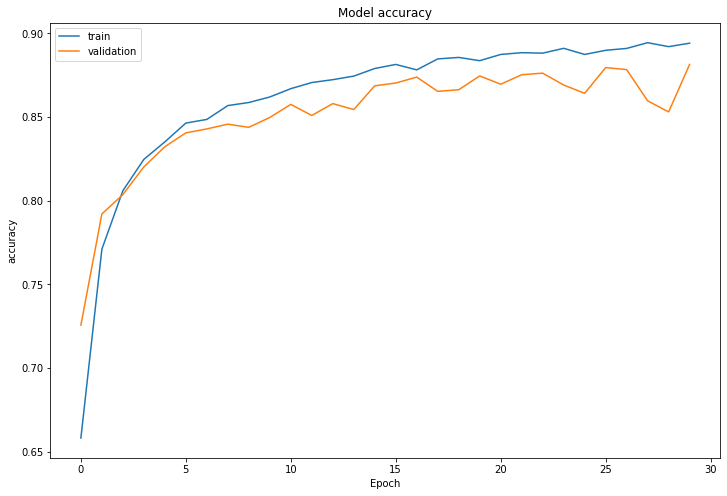

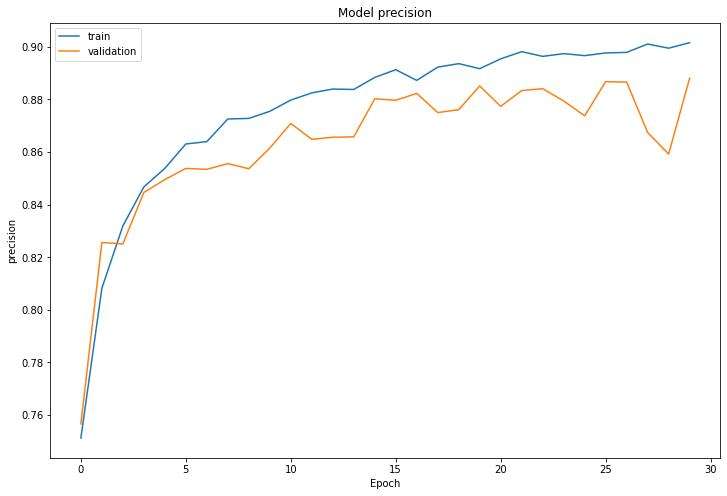

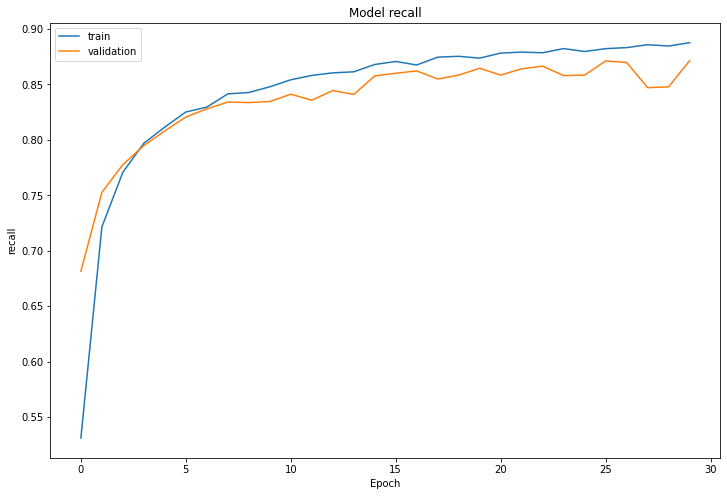

In [12]:
metrics = list(historyC.history.keys())

df = pd.DataFrame(historyC.history)

for i in range(len(l)//2):
    tr = metrics[i]
    val = "val_" + tr
    df_pl= df[[tr,val]]
    df_pl.rename(columns={tr:'train',val:'validation'},inplace=True)
    df_pl.plot(title='Model '+tr,figsize=(12,8)).set(xlabel='Epoch',ylabel=tr)

In [13]:
loss, acc, pre, re = conv_model.evaluate(val_ds, batch_size = 64)
print("The loss on 64 elements of the validation set is", loss,
      "\nThe accuracy on those elements is", acc, 
      "\nThe Precision of the model is", pre, 
      "\nThe recall of the model is", re)

133/133 [==============================] - 12s 82ms/step - loss: 0.3332 - accuracy: 0.8814 - precision: 0.8881 - recall: 0.8715
The loss on 64 elements of the validation set is 0.333236426115036 
The accuracy on those elements is 0.8814079761505127 
The Precision of the model is 0.888059675693512 
The recall of the model is 0.8714859485626221
